In [26]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import geopandas as gp

In [458]:
def Get_FIPS(df, state):
    """
    df: DataFrame
    state: U.S. State Name (e.g. California, Idaho, etc.)
    
    Returns array of U.S. Counties' FIPS Codes.
    """
    
    state_df = df[df['state'] == state]
    fips_array = state_df['FIPS'].unique()
    
    return fips_array

def County_Winners(df, state, method='categorical'):
    """
    df: DataFrame
    state: U.S. State Name (e.g. California, Idaho, etc.)
    method: 
    
    Returns 
    """
    assert method is 'categorical' or 'continuous', "Please choose either 'categorical' or 'continuous'"
    if method is 'categorical':
        max_col = 'party'
    elif method is 'continuous':
        max_col = 'proportion'
    
    state_df = df[df['state'] == state]
    election_years = state_df['year'].unique()
    winners_container = [[] for _ in range(len(election_years))]
    
    for idx, year in enumerate(election_years):
        winners = state_df[state_df['year'] == year].groupby('FIPS').apply(
            lambda county: county[max_col][county['candidatevotes'].idxmax()]).values
        winners_container[idx] = winners
            
    return winners_container

def County_Winners_DF(df, method='categorical'):
    """
    df: 
    
    Returns 
    """
    states = df['state'].unique()
    list_counties, list_fips = [], []
    list_2000, list_2004 = [], []
    list_2008, list_2012 = [], []
    list_2016 = []
    
    for state in states:
        fips = Get_FIPS(df=df, state=state)
        county_winners = County_Winners(df=df, state=state, method=method)
        list_fips.extend(fips)
        list_2000.extend(county_winners[0])
        list_2004.extend(county_winners[1])
        list_2008.extend(county_winners[2])
        list_2012.extend(county_winners[3])
        list_2016.extend(county_winners[4])
    
    final_dataframe = pd.DataFrame({
    'countyFIPS': list_fips,
    '2000': list_2000, '2004': list_2004, 
    '2008': list_2008, '2012': list_2012,
    '2016': list_2016})
    
    if method is 'categorical':
        final_dataframe.replace({'republican': 1, 'democrat': 0}, inplace=True)
    else:
        pass
        
    final_dataframe['Total'] = final_dataframe.loc[:, ('2000', '2004', '2008', '2012', '2016')].sum(axis=1)
    
    return final_dataframe

---

# County Pres. 2000 - 2016

In [394]:
abridged = pd.read_csv('abridged_couties.csv', usecols=['stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 
        'restaurant dine-in', 'entertainment/gym', 'countyFIPS', 'State', 'CountyName', 'STATEFP', 'COUNTYFP'])
abridged['countyFIPS'] = abridged['countyFIPS'][:-2].astype(int, copy=False)

county_pres_df = pd.read_csv('countypres_2000-2016.csv')
county_pres_df = county_pres_df[(county_pres_df['party'] == 'democrat') | (county_pres_df['party'] == 'republican')]
county_pres_df.dropna(inplace=True)
county_pres_df = county_pres_df[(county_pres_df['county'] != 'Broomfield') & 
                                (county_pres_df['county'] != 'Kansas City') &
                                (county_pres_df['county'] != 'Bedford')]

county_pres_df.loc[:, 'proportion'] = county_pres_df.loc[:, 'candidatevotes'] / county_pres_df.loc[:, 'totalvotes']
county_pres_df.loc[::2, 'proportion'] = -county_pres_df.loc[::2, 'proportion']

shape = gp.read_file('cb_2018_us_county_5m.shp')
shape = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')]
shape['STATEFP'] = shape['STATEFP'].astype(float)
shape['COUNTYFP'] = shape['COUNTYFP'].astype(float)

In [386]:
county_winners_cat_df = County_Winners_DF(county_pres_df)
county_winners_cont_df = County_Winners_DF(test_2, method='continuous')

In [387]:
cat_merged = abridged.merge(county_winners_cat_df, on='countyFIPS', how='inner')
cont_merged = abridged.merge(county_winners_cont_df, on='countyFIPS', how='inner')

### Dist. Plots Based on Categorical County Classifying Method

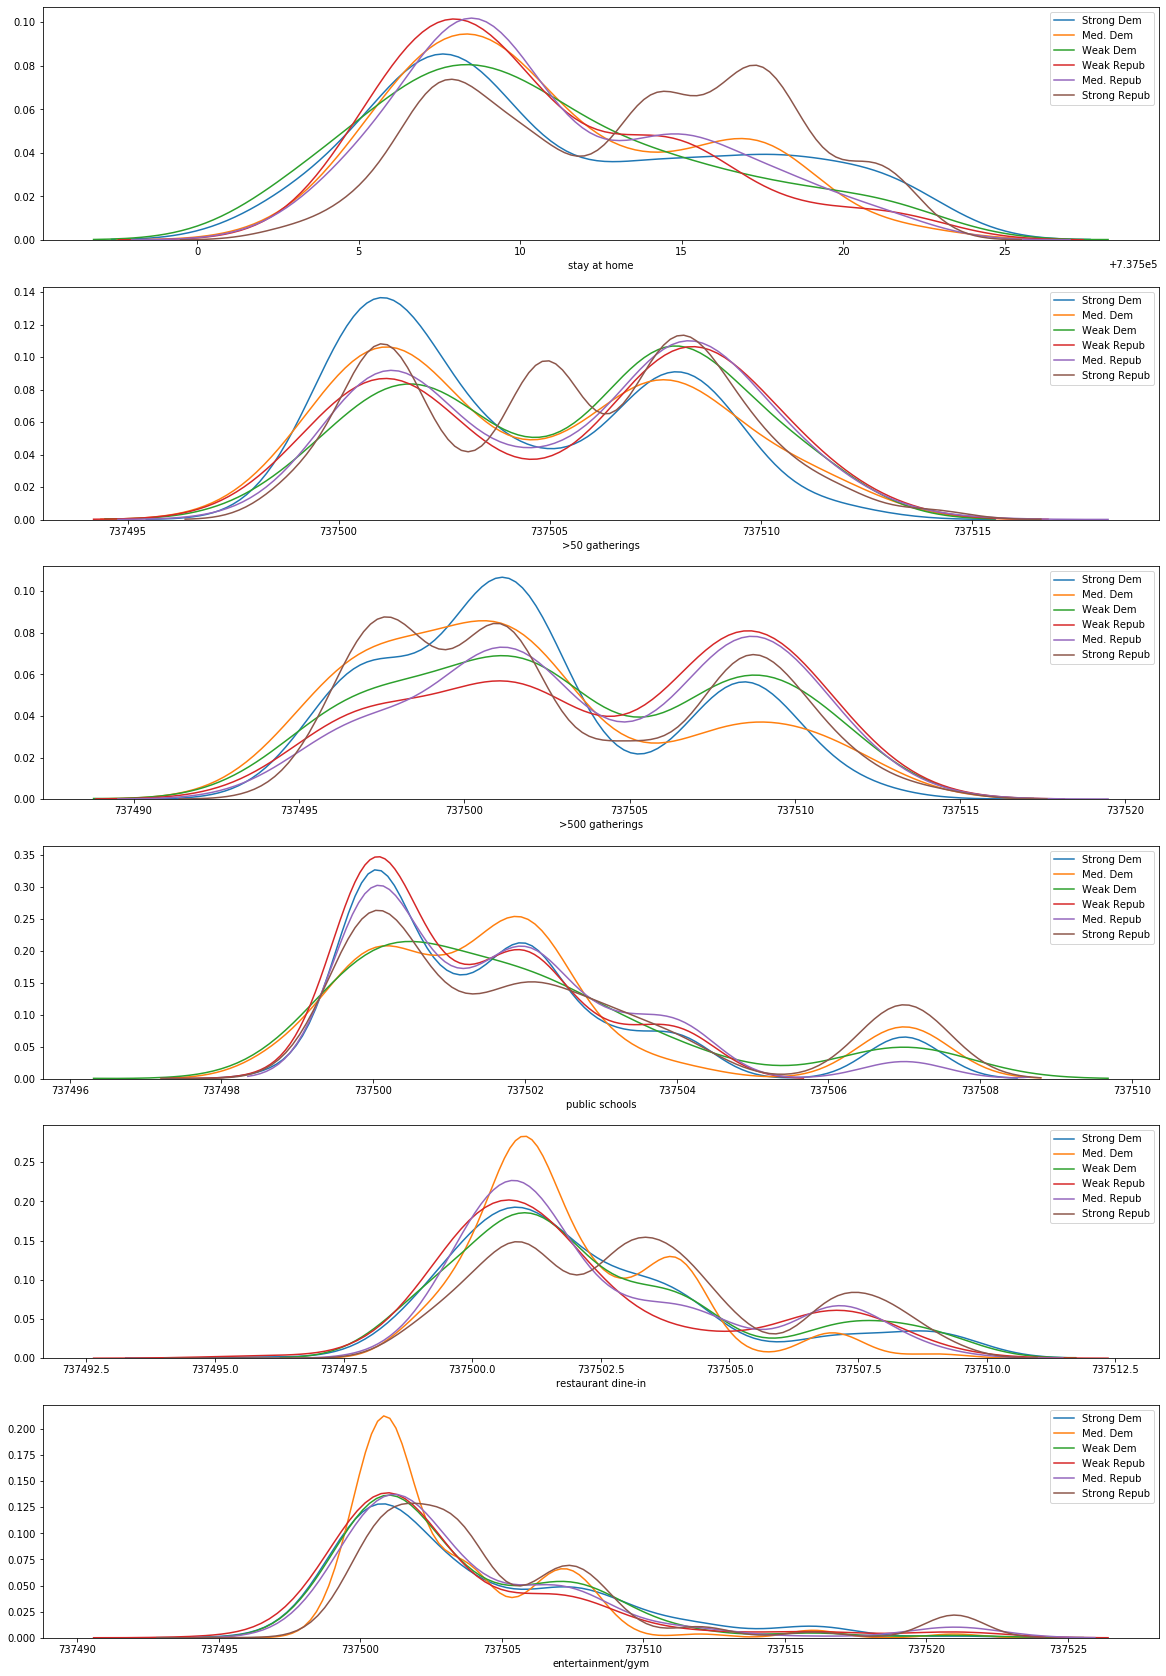

In [388]:
fig, axes = plt.subplots(6, 1, figsize=(20,5*6))
dist_df = cat_merged.dropna().loc[:, ('stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'Total')]
columns = dist_df.iloc[:, :-1].columns.tolist()

for ax_position, column in enumerate(columns):
    sns.distplot(dist_df[dist_df['Total'] == 0].loc[:,column], hist=False, label='Strong Dem', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 1].loc[:,column], hist=False, label='Med. Dem', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 2].loc[:,column], hist=False, label='Weak Dem', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 3].loc[:,column], hist=False, label='Weak Repub', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 4].loc[:,column], hist=False, label='Med. Repub', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 5].loc[:,column], hist=False, label='Strong Repub', ax=axes[ax_position])
    
plt.legend();

### Scatter Plot with Continuous County Classifying Method

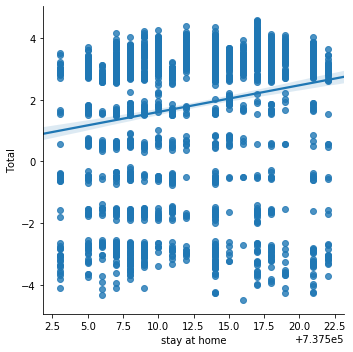

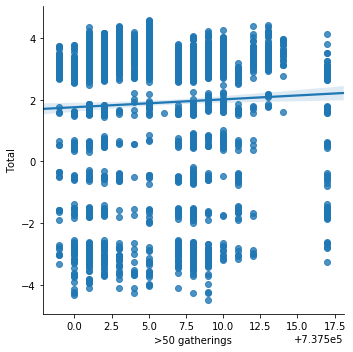

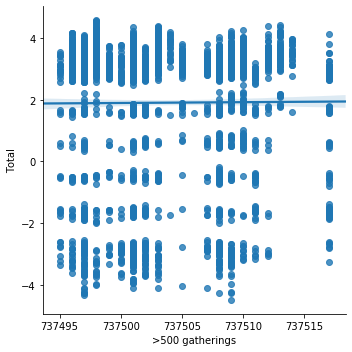

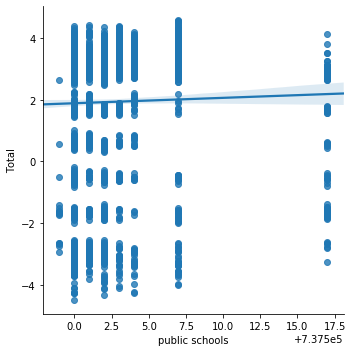

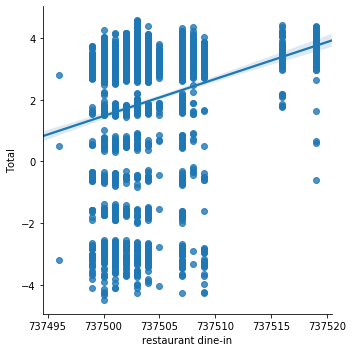

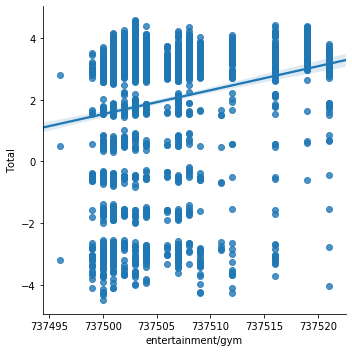

In [457]:
# y is county political range with 5 being whole county voted republican for the past five elections and 
# -5 being the opposite but for dems
for column in cont_merged.columns.tolist()[5:11]:
    sns.lmplot(column, 'Total', cont_merged)

### Map Plot of Categorical County Classifying Method

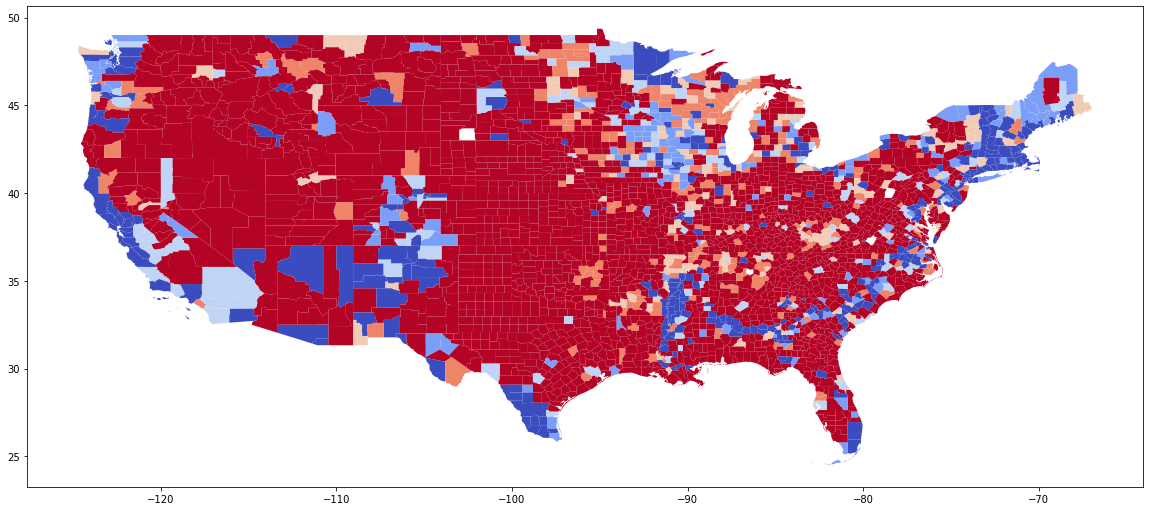

In [399]:
merged_shape_cat = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')].merge(cat_merged.loc[:, ('Total', 'STATEFP', 'COUNTYFP')], 
                                                            on=['STATEFP', 'COUNTYFP']).loc[:, ('Total', 'geometry')]
merged_shape_cat = merged_shape_cat.cx[-130:-50, 20:]

merged_shape_cat.plot(column='Total', cmap='coolwarm', figsize=(20,10), linewidth=0, edgecolor='white');

### Map Plot of Continuous County Classifying Method

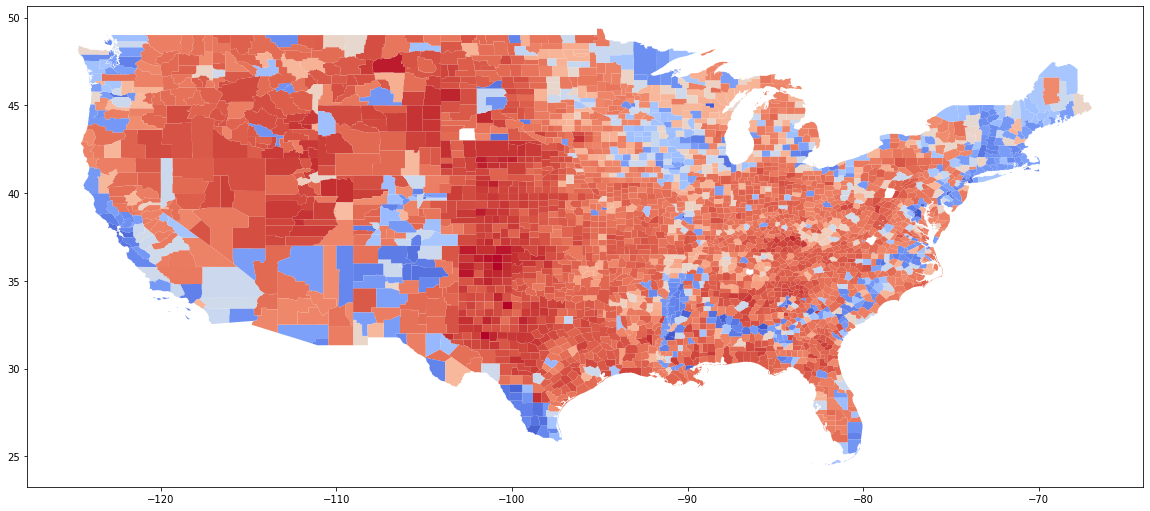

In [400]:
merged_shape_cont = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')].merge(cont_merged.loc[:, ('Total', 'STATEFP', 'COUNTYFP')], 
                                                            on=['STATEFP', 'COUNTYFP']).loc[:, ('Total', 'geometry')]
merged_shape_cont = merged_shape_cont.cx[-130:-50, 20:]

merged_shape_cont.plot(column='Total', cmap='coolwarm', figsize=(20,10), linewidth=0, edgecolor='white');

----

### Google Mobility Report (Work in Progress)

In [460]:
mob = pd.read_csv('Global_Mobility_Report.csv')
mob = mob[mob['country_region'] == 'United States'].iloc[:, 2:]
mob.reset_index(inplace=True)
mob.drop(columns='index', inplace=True)
mob.columns = ['State', 'CountyName', 'date', 'retail', 'grocery', 
               'parks', 'transit', 'workplaces', 'residential']
mob.head()

,State,CountyName,date,retail,grocery,parks,transit,workplaces,residential
0,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,NaN,NaN,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,NaN,NaN,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [466]:
mob_test = mob[mob['State'] == 'Alabama']
mob_test.loc[:, 'CountyName'] = mob_test.loc[:, 'CountyName'].str.replace(' County', '')
mob_test.iloc[:, 1:].groupby('CountyName').mean()

,retail,grocery,parks,transit,workplaces,residential
CountyName,,,,,,
Autauga,-11.805556,7.222222,-34.000000,NaN,-19.416667,8.660000
Baldwin,-16.208333,1.791667,7.680556,-8.277778,-17.069444,6.513889
Barbour,1.259259,-6.490196,NaN,NaN,-13.069444,NaN
Bibb,0.823529,5.823529,NaN,NaN,-14.875000,NaN
Blount,-8.098361,4.328571,NaN,NaN,-17.861111,8.240000
...,...,...,...,...,...,...
Tuscaloosa,-17.069444,0.847222,1.742857,-9.138889,-22.388889,8.861111
Walker,-11.291667,1.916667,NaN,-9.875000,-11.944444,6.039216
Washington,NaN,8.039216,NaN,NaN,-13.040000,NaN


In [493]:
mob_test_winst = mob_test[mob_test['CountyName'] == 'Winston']
mob_test_winst.loc[:, 'date'] = pd.to_datetime(mob_test_winst['date'])
mob_test_winst.loc[:, 'date'] = mob_test_winst.date.map(pd.Timestamp.toordinal)

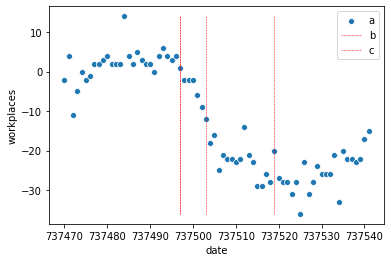

In [527]:
sns.scatterplot('date', 'workplaces', data=mob_test_winst)
plt.vlines(737519, mob_test_winst['workplaces'].min(), 
           mob_test_winst['workplaces'].max(), color='r', ls='dashed', lw=0.5)
plt.vlines(737503, mob_test_winst['workplaces'].min(), 
           mob_test_winst['workplaces'].max(), color='r', ls='dashed', lw=0.5)
plt.vlines(737497, mob_test_winst['workplaces'].min(), 
           mob_test_winst['workplaces'].max(), color='r', ls='dashed', lw=0.5)
plt.vlines(737497, mob_test_winst['workplaces'].min(), 
           mob_test_winst['workplaces'].max(), color='r', ls='dashed', lw=0.5)
plt.legend(['a', 'b', 'c']);

In [ ]:
sns.scatterplot('date', 'workplaces', data=mob_test_winst)
for key, value in 

In [479]:
mob_test_winst['workplaces'].min()

-36.0

In [498]:
abridged[(abridged['CountyName'] == 'Winston') &
         (abridged['State'] == 'Alabama')].loc

AttributeError: 'list' object has no attribute 'contains'

In [568]:
Get_County_Orders(abridged, 'Alabama', 'Winston')

,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym
66,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0


In [547]:
def Get_County_Orders(df, state, county):
    order_columns = ('stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
                     'restaurant dine-in', 'entertainment/gym')
    orders = df[(df['State'] == state) & (df['CountyName'] == county)]
    return orders.loc[:, order_columns]

In [573]:
mob_test_winst[mob_test_winst['date'] > 737497.0].groupby('CountyName').mean()

,date,retail,grocery,parks,transit,workplaces,residential
CountyName,,,,,,,
Winston,737519.5,-16.521739,9.782609,NaN,NaN,-21.568182,NaN


In [401]:
abridged[(abridged['CountyName'] == 'Winston') &
         (abridged['State'] == 'Alabama')].merge(mob_test[mob_test['CountyName'] == 'Winston'],
                                                 on=['State', 'CountyName'])

,countyFIPS,STATEFP,COUNTYFP,CountyName,State,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,date,retail,grocery,parks,transit,workplaces,residential
0,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-02-15,0.0,0.0,NaN,NaN,-2.0,NaN
1,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-02-16,-3.0,0.0,NaN,NaN,4.0,NaN
2,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-02-17,-3.0,-11.0,NaN,NaN,-11.0,NaN
3,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-02-18,-12.0,-10.0,NaN,NaN,-5.0,NaN
4,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-02-19,4.0,8.0,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-04-22,NaN,NaN,NaN,NaN,-22.0,NaN
68,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-04-23,NaN,NaN,NaN,NaN,-23.0,NaN
69,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-04-24,NaN,NaN,NaN,NaN,-22.0,NaN
70,1133.0,1.0,133.0,Winston,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,2020-04-25,NaN,NaN,NaN,NaN,-17.0,NaN
